In [45]:
# Standard modules
import pdb
import sys
import os
import pickle
import emcee
import scipy
from scipy.integrate import quad
import numpy as np
import pandas as pd
from lmfit import Parameters, minimize, fit_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sys.path.append("..")

from simstackwrapper import SimstackWrapper
from simstackresults import SimstackResults
from simstackplots import SimstackPlots

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
# Function to import saved stacking results
def import_saved_pickles(pickle_fn):
    with open(pickle_fn, "rb") as file_path:
        encoding = pickle.load(file_path)
    return encoding

In [3]:
# Define Pickled Stacking Results File for Importing
pickle_filename = 'cosmos2020_nuvrj_1p5_2_2p5_3_3p5_background_atonce_farmer_bootstrap_100'
pickle_path = os.path.join("..","test_data","pickles",pickle_filename)
path_pickle_file = os.path.join(pickle_path, pickle_filename+".pkl")
print(os.path.isfile(path_pickle_file))

True


In [4]:
# Import saved stacking results
simstack_object = import_saved_pickles(path_pickle_file)

In [5]:
# Import Catalog with SimstackWrapper
path_ini_file = os.path.join(pickle_path, "cosmos2020_alt_binning.ini")
print(path_ini_file,os.path.isfile(path_ini_file))
simstack_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)

..\test_data\pickles\cosmos2020_nuvrj_1p5_2_2p5_3_3p5_background_atonce_farmer_bootstrap_100\cosmos2020_alt_binning.ini True


In [6]:
# Pass saved stacking object into SimstackResults
simstack_object = SimstackResults(simstack_object)

In [7]:
# Pass aved stacking object into SimstackPlots
simstack_object = SimstackPlots(simstack_object)

In [8]:
# Call parse_results which creates converts the raw results into a results_dict for plotting/interpreting.
simstack_object.parse_results(catalog_object=simstack_catalog_object, estimate_mcmcs=False)

In [9]:
# SED measurements and bootstraps stored in sed_results_dict
sed_results_dict = simstack_object.results_dict['sed_bootstrap_results_dict']

In [10]:
sed_results_dict.keys()

dict_keys(['wavelengths', 'z_median', 'm_median', 'ngals', 'sed_fluxes_dict', 'std_fluxes_dict', 'sed_bootstrap_fluxes_dict'])

## Improve SED estimator to include survival function for upper limits

In [11]:
def log_likelihood(theta, x, y, cov):
    y_model = fast_scipy_sed(theta, x)
    delta_y = y - y_model[0]
    ll = -0.5 * (np.matmul(delta_y, np.matmul(np.linalg.inv(cov), delta_y)) 
                 + len(y) * np.log(2 * np.pi) 
                 + np.log(np.linalg.det(cov)))
    if not np.isfinite(ll):
        return -np.inf
    return ll

def log_likelihood_full(theta, x_d, y_d, cov_d, x_nd=None, y_nd=None, dy_nd=None):
    
    _sed_params = Parameters()
    _sed_params.add('A', value=theta[0], vary=True)
    _sed_params.add('T_observed', value=theta[1], vary=True)
    _sed_params.add('beta', value=1.8, vary=False)
    _sed_params.add('alpha', value=2.0, vary=False)
    
    y_model_d = fast_lmfit_sed(_sed_params, x_d)
    
    y_model_nd = fast_lmfit_sed(_sed_params, x_nd)
    
    # log likelihood for detections
    delta_y = y_d - y_model_d[0]
    ll_d = -0.5 * (np.matmul(delta_y, np.matmul(np.linalg.inv(cov_d), delta_y)) 
                   + len(y_d) * np.log(2 * np.pi) 
                   + np.log(np.linalg.det(cov_d)))
    
    # log likelihood for non-detections
    ll_nd = 0.
    if x_nd is not None:
        for j, y_nd_j in enumerate(y_nd):
            _integrand_j = lambda yy: np.exp(-0.5*((yy-y_model_nd[0][j])/dy_nd[j])**2)
            _integral_j = quad(_integrand_j, 0., y_nd_j)[0]
            ll_nd += np.log(_integral_j)
    else:
        pass
    
    #print('check ll_d and ll_nd:', ll_d, ll_nd)
    
    if not np.isfinite(ll_d + ll_nd):
        return -np.inf
    
    return ll_d + ll_nd

def log_prior(theta):
    A, T = theta[0], theta[1]
    Amin = -42
    Amax = -26
    Tmin = 1
    Tmax = 32

    if Amin < A < Amax and Tmin < T < Tmax:
        return 0.0
    else:
        return -np.inf

def log_prior_informative(theta, theta0):
    A, T = theta
    A0, T0, sigma_A, sigma_T = theta0
    Amin = -42
    Amax = -26
    Tmin = 1
    Tmax = 32
    error_infl = 1.0

    if Amin < A < Amax and Tmin < T < Tmax and sigma_A is not None and sigma_T is not None:
        try:
            lp = -0.5 * (np.sum((10**A - 10**A0) ** 2 / (10**sigma_A * error_infl) ** 2) +
                         np.sum((T - T0) ** 2 / (sigma_T * error_infl) ** 2)) + \
                 np.log(1.0/(np.sqrt(2*np.pi)*(10**sigma_A))) + np.log(1.0/(np.sqrt(2*np.pi)*sigma_T))
        except:
            pdb.set_trace()
        return lp
    return -np.inf

def log_probability(theta, x, y, yerr, theta0):
    lp = log_prior_informative(theta, theta0)
    #pdb.set_trace()
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

def log_probability_full(theta, x_d, y_d, cov_d, x_nd=None, y_nd=None, dy_nd=None):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_full(theta, x_d, y_d, cov_d, x_nd, y_nd, dy_nd)

In [51]:
def mcmc_sed_estimator(x, y, yerr, theta, mcmc_iterations=2500, mcmc_discard=25):

    pos = np.array([theta[0], theta[1]]) + 1e-1 * np.random.randn(32, 2)
    nwalkers, ndim = pos.shape

    # Define non-detection as 1-sigma error below 0
    yerr_diag = np.diag(yerr)
    ind_nd = (y - np.sqrt(yerr_diag)) < 0

    # Split detections and non-detections (nd). Remove nd rows/columns from yerr matrix
    x  = np.array(x)
    wvs = x[ind_nd == False]
    fluxes = y[ind_nd == False]
    cov_fluxes = yerr
    if np.sum(ind_nd):
        for i in np.where(ind_nd)[::-1]:
            cov_fluxes = np.delete(cov_fluxes,i,axis=0)
            cov_fluxes = np.delete(cov_fluxes,i,axis=1)

        wvs_nd = x[ind_nd == True]
        fluxes_nd = y[ind_nd == True]
        dfluxes_nd = yerr_diag[ind_nd == True]
    else:
        wvs_nd=None
        fluxes_nd=None
        dfluxes_nd=None
            
    pdb.set_trace()
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability_full, args=(wvs, fluxes, cov_fluxes, wvs_nd, fluxes_nd, dfluxes_nd)
    )
    sampler.run_mcmc(pos, mcmc_iterations, progress=True)
    flat_samples = sampler.get_chain(discard=mcmc_discard, thin=15, flat=True)

    return flat_samples

In [52]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_3.0_3.5__stellar_mass_10.0_10.5__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=500, mcmc_discard=5)

> <ipython-input-51-4020d15e2007>(24)mcmc_sed_estimator()
     22     dfluxes_nd = yerr_diag[ind_d == True]
     23     pdb.set_trace()
---> 24     sampler = emcee.EnsembleSampler(
     25         nwalkers, ndim, log_probability_full, args=(wvs, fluxes, cov_fluxes, wvs_nd, fluxes_nd, dfluxes_nd)
     26     )

ipdb> cov_fluxes
array([[2.23636547e-11, 4.83908551e-10, 5.75668122e-10, 4.79547479e-10,
        2.32138431e-10, 3.14341263e-11],
       [4.83908551e-10, 5.19797076e-08, 2.21319420e-08, 2.44274090e-08,
        2.05262733e-08, 2.00526820e-10],
       [5.75668122e-10, 2.21319420e-08, 1.15577317e-07, 1.23493464e-07,
        9.69126604e-08, 4.73310917e-09],
       [4.79547479e-10, 2.44274090e-08, 1.23493464e-07, 1.53731010e-07,
        1.31623986e-07, 4.77743599e-09],
       [2.32138431e-10, 2.05262733e-08, 9.69126604e-08, 1.31623986e-07,
        1.29905520e-07, 2.28706882e-09],
       [3.14341263e-11, 2.00526820e-10, 4.73310917e-09, 4.77743599e-09,
        2.28706882e-09, 5.29745816

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 27.10it/s]


In [13]:
def target_function(theta, x_d, y_d, cov_d, x_nd, y_nd, dy_nd):
    return -log_likelihood_full(theta, x_d, y_d, cov_d, x_nd, y_nd, dy_nd)

result = scipy.optimize.minimize(target_function, x0=[-31.0, 9.0], 
                                 args=(wvs, fluxes, cov_fluxes, wvs_nd, fluxes_nd, dfluxes_nd))
print(result)

NameError: name 'wvs' is not defined

In [14]:
def estimate_mcmc_sed(sed_bootstrap_dict, id_label, z_median=0,
                      mcmc_iterations=2500, mcmc_discard=25):

    if not z_median:
        z_label = id_label.split('_')[1:3]
        z_median = np.mean([float(i) for i in z_label])

    x = sed_bootstrap_dict['wavelengths']
    y = sed_bootstrap_dict['sed_fluxes_dict'][id_label]
    yerr = np.cov(sed_bootstrap_dict['sed_bootstrap_fluxes_dict'][id_label], rowvar=False)

    sed_params = fast_sed_fitter(x, y, yerr)
    graybody = fast_lmfit_sed(sed_params, x)[0]
    delta_y = y - graybody
    med_delta = np.median(y / delta_y)

    Ain = sed_params['A'].value
    Aerr = sed_params['A'].stderr
    Tin = sed_params['T_observed'].value
    Terr = sed_params['T_observed'].stderr

    if Tin is None:
        Tin = (10 ** (1.2 + 0.1 * z_median)) / (1 + z_median)
    if Terr is None:
        Terr = Tin * med_delta
    if Ain is None:
        Ain = -39
    if Aerr is None:
        Aerr = Ain * med_delta

    theta0 = Ain, Tin, Aerr, Terr

    if np.isfinite(np.log(np.linalg.det(yerr))):
        flat_samples = mcmc_sed_estimator(x, y, yerr, theta0, mcmc_iterations=mcmc_iterations,
                                          mcmc_discard=mcmc_discard)
    else:
        return -np.inf

    return flat_samples, theta0

In [15]:
def fast_lmfit_sed(m, wavelengths):
    c = 299792458.0  # m/s
    nu_in = np.array([c * 1.e6 / wv for wv in wavelengths])

    v = m.valuesdict()
    A = np.asarray(v['A'])
    T = np.asarray(v['T_observed'])
    betain = np.asarray(v['beta'])
    alphain = np.asarray(v['alpha'])
    ng = np.size(A)

    base = 2.0 * (6.626) ** (-2.0 - betain - alphain) * (1.38) ** (3. + betain + alphain) / (2.99792458) ** 2.0
    expo = 34.0 * (2.0 + betain + alphain) - 23.0 * (3.0 + betain + alphain) - 16.0 + 26.0
    K = base * 10.0 ** expo
    w_num = 10 ** A * K * (T * (3.0 + betain + alphain)) ** (3.0 + betain + alphain)
    w_den = (np.exp(3.0 + betain + alphain) - 1.0)
    w_div = w_num / w_den
    nu_cut = (3.0 + betain + alphain) * 0.208367e11 * T
    graybody = np.reshape(10 ** A, (ng, 1)) * nu_in ** np.reshape(betain, (ng, 1)) * black(nu_in, T) / 1000.0
    powerlaw = np.reshape(w_div, (ng, 1)) * nu_in ** np.reshape(-1.0 * alphain, (ng, 1))
    graybody[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))] = \
        powerlaw[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))]

    return graybody

In [16]:
def fast_scipy_sed(theta, x):
    A, T = theta

    alphain = 2.0
    betain = 1.8
    c_light = 299792458.0  # m/s

    nu_in = np.array([c_light * 1.e6 / wv for wv in x])
    ng = np.size(A)

    base = 2.0 * (6.626) ** (-2.0 - betain - alphain) * (1.38) ** (3. + betain + alphain) / (2.99792458) ** 2.0
    expo = 34.0 * (2.0 + betain + alphain) - 23.0 * (3.0 + betain + alphain) - 16.0 + 26.0
    K = base * 10.0 ** expo
    w_num = 10 ** A * K * (T * (3.0 + betain + alphain)) ** (3.0 + betain + alphain)
    w_den = (np.exp(3.0 + betain + alphain) - 1.0)
    w_div = w_num / w_den
    nu_cut = (3.0 + betain + alphain) * 0.208367e11 * T
    graybody = np.reshape(10 ** A, (ng, 1)) * nu_in ** np.reshape(betain, (ng, 1)) * black(nu_in, T) / 1000.0
    powerlaw = np.reshape(w_div, (ng, 1)) * nu_in ** np.reshape(-1.0 * alphain, (ng, 1))
    graybody[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))] = \
        powerlaw[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))]

    return graybody

In [17]:
def black(nu_in, T):
    # h = 6.623e-34     ; Joule*s
    # k = 1.38e-23      ; Joule/K
    # c = 3e8           ; m/s
    # (2*h*nu_in^3/c^2)*(1/( exp(h*nu_in/k*T) - 1 )) * 10^29

    a0 = 1.4718e-21  # 2*h*10^29/c^2
    a1 = 4.7993e-11  # h/k

    num = a0 * nu_in ** 3.0
    den = np.exp(a1 * np.outer(1.0 / T, nu_in)) - 1.0
    ret = num / den

    return ret

In [18]:
def loggen(minval, maxval, npoints, linear=None):
    points = np.arange(npoints) / (npoints - 1)
    if (linear != None):
        return (maxval - minval) * points + minval
    else:
        return 10.0 ** ((np.log10(maxval / minval)) * points + np.log10(minval))

In [19]:
def survival(z):
    lim = 37
    nsteps = 300
    s = np.zeros(np.shape(z))
    s[z < -lim] = 1    
    s[z > lim] = 0
    index = abs(z) <= lim
    for i in range(len(index)):
        bins = loggen(z[index[i]], lim, nsteps)
        step = bins[1] - bins[0]
        s[index[i]] = np.sum( gauss(bins+step/2.) )*step/np.sqrt(2*np.pi)

In [20]:
def fast_sed_fitter(wavelengths, fluxes, covar, betain=1.8, redshiftin=0):
    t_in = (10 ** (1.2 + 0.1 * redshiftin)) / (1+redshiftin)
    a_in = -34.0
    fit_params = Parameters()
    fit_params.add('A', value=a_in, vary=True)
    fit_params.add('T_observed', value=t_in, max=t_in*1.3, vary=True)
    fit_params.add('beta', value=betain, vary=False)
    fit_params.add('alpha', value=2.0, vary=False)

    try:
        sed_params = minimize(find_sed_min, fit_params,
                              args=(wavelengths,),
                              kws={'fluxes': fluxes, 'covar': covar})
        m = sed_params.params
    except:
        print('fucked!')
        m = fit_params

    return m

def find_sed_min(params, wavelengths, fluxes, covar=None):

    graybody = fast_lmfit_sed(params, wavelengths)[0]
    delta_y = (fluxes - graybody)

    #survival_value = survival(graybody/fluxes-2)
    #if ind[0] ne -1 then chisq_lim -= total(alog(survival_value)) ;survival = 1 if model << flux, = 0.5 if model = flux, = 0 if model >> flux
    if (covar is None) or (np.sum(covar) == 0):
        return delta_y
    else:
        if np.shape(covar) == np.shape(fluxes):
            return delta_y ** 2 / covar
        else:
            #pdb.set_trace()
            #return np.matmul(delta_y, np.matmul(np.linalg.inv(covar), delta_y))
            return np.matmul(delta_y**2, np.linalg.inv(covar))

In [21]:
from scipy import optimize

def fn(x, a, b, c):
    return a*x**2 + b*x + c

def residual(pa, x, y):
    return y - fn(x, *pa)

f = np.poly1d([-5, 1, 3])
x = np.linspace(0, 2, 20)
y = f(x) + 1.5*np.random.normal(size=len(x))

p0 = [1., 1., 1.]
popt, pcov = optimize.leastsq(residual, p0, args=(x, y))

print(popt)
print(pcov)

def fast_lmfit_sed2(theta, gamma, wavelengths):
    c = 299792458.0  # m/s
    nu_in = np.array([c * 1.e6 / wv for wv in wavelengths])

    A, T = theta
    betain, alphain = gamma
    ng = np.size(A)

    base = 2.0 * (6.626) ** (-2.0 - betain - alphain) * (1.38) ** (3. + betain + alphain) / (2.99792458) ** 2.0
    expo = 34.0 * (2.0 + betain + alphain) - 23.0 * (3.0 + betain + alphain) - 16.0 + 26.0
    K = base * 10.0 ** expo
    w_num = 10 ** A * K * (T * (3.0 + betain + alphain)) ** (3.0 + betain + alphain)
    w_den = (np.exp(3.0 + betain + alphain) - 1.0)
    w_div = w_num / w_den
    nu_cut = (3.0 + betain + alphain) * 0.208367e11 * T
    graybody = np.reshape(10 ** A, (ng, 1)) * nu_in ** np.reshape(betain, (ng, 1)) * black(nu_in, T) / 1000.0
    powerlaw = np.reshape(w_div, (ng, 1)) * nu_in ** np.reshape(-1.0 * alphain, (ng, 1))
    graybody[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))] = \
        powerlaw[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))]

    return graybody

def fast_sed_fitter2(wvs, flux, cov, betain=1.8, redshiftin=0):
    T0 = (10 ** (1.2 + 0.1 * redshiftin)) / (1+redshiftin)
    A0 = -34.0
    theta0 = A0, T0
    gamma0 = betain, 2.0
    popt, pcov = optimize.leastsq(find_sed_min2, theta0, args=(wvs, flux, cov, gamma0))
    
    return popt, pcov

def find_sed_min2(theta, wavelengths, fluxes, covar, gamma):

    graybody = fast_lmfit_sed2(theta, gamma, wavelengths)[0]
    delta_y = (fluxes - graybody)

    #pdb.set_trace()
    return np.matmul(delta_y**2, np.linalg.inv(covar))

[-4.74640912  1.08105981  3.08774484]
1


# Test Code on Data

In [49]:
def plot_test_mcmc_seds(self, mcmc_dict, flat_samples, theta0, id_label, bootstrap_dict=None, errors=('25', '75')):
    bin_keys = list(self.config_dict['parameter_names'].keys())
    wvs = mcmc_dict['wavelengths']
    wv_array = self.loggen(8, 1000, 100)
    ngals = mcmc_dict['ngals']
    z_med = mcmc_dict['z_median']
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 7))
    axs.text(9.0e0, 1e2, "Ngals={0:.0f}".format(ngals[id_label]))
    
    y = mcmc_dict['sed_fluxes_dict'][id_label]
    yerr = np.cov(mcmc_dict['sed_bootstrap_fluxes_dict'][id_label], rowvar=False)
    
    Ain, Tin, Aerr, Terr = theta0
    sed_params = Parameters()
    sed_params.add('A', value=Ain, vary=True)
    sed_params.add('T_observed', value=Tin, max=Tin*1.3, vary=True)
    sed_params.add('beta', value=1.8, vary=False)
    sed_params.add('alpha', value=2.0, vary=False)
    sed_array =  fast_lmfit_sed(sed_params, wv_array)
    
    axs.plot(wv_array, sed_array[0] * 1e3, color='k', lw=0.5)
    
    if np.sum(y > 0):
        prior_label = "A0={0:.1f}+-{1:.1f}, Trf0={2:.1f}+-{3:.1f}".format(Ain, Aerr, Tin * (1 + z_med[id_label]), Terr)
        axs.text(9.0e0, 1.75e2, prior_label)

        mcmc_out = [np.percentile(flat_samples[:, i], [float(errors[0]), 50, float(errors[1])])
                    for i in range(np.shape(flat_samples)[1])]
        mcmc_lo = fast_scipy_sed([mcmc_out[0][0], mcmc_out[1][0]], wv_array)
        mcmc_50 = fast_scipy_sed([mcmc_out[0][1], mcmc_out[1][1]], wv_array)
        mcmc_hi = fast_scipy_sed([mcmc_out[0][2], mcmc_out[1][2]], wv_array)
        mcmc_label = "A={0:.1f}, Trf={1:.1f}".format(mcmc_out[0][1], mcmc_out[1][1] * (1 + z_med[id_label]))

        axs.plot(wv_array, mcmc_50[0] * 1e3, color='c', lw=0.8, label=mcmc_label)
        axs.fill_between(wv_array, mcmc_lo[0] * 1e3, mcmc_hi[0] * 1e3, facecolor='c',
                                 alpha=0.3, edgecolor='c')
    else:
        pdb.set_trace()
        
    for iwv, wv in enumerate(wvs):
        if wv in [24, 70]:
            color = 'b'
        elif wv in [100, 160]:
            color = 'g'
        elif wv in [250, 350, 500]:
            color = 'r'
        elif wv in [850]:
            color = 'y'

        if bootstrap_dict is not None:
            for iboot in range(len(bootstrap_dict['sed_bootstrap_fluxes_dict'][id_label.replace('.', 'p')])):
                yplot_boot = bootstrap_dict['sed_bootstrap_fluxes_dict'][id_label.replace('.', 'p')][iboot] * 1e3
                axs.scatter(wvs, yplot_boot, color=color, alpha=0.1)

        axs.scatter(wv, y[iwv] * 1e3, marker='o', s=90, facecolors='none', edgecolors=color)
        axs.errorbar(wv, y[iwv] * 1e3, yerr=np.sqrt(np.diag(yerr)[iwv]) * 1e3,
                             fmt="." + color, capsize=0)

    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.set_ylim([5e-3, 5e2])
    axs.legend(loc='upper left', frameon=False)
    axs.set_title(id_label)

In [48]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_3.0_3.5__stellar_mass_10.0_10.5__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=500, mcmc_discard=5)

> <ipython-input-47-4020d15e2007>(24)mcmc_sed_estimator()
     22     dfluxes_nd = yerr_diag[ind_d == True]
     23     pdb.set_trace()
---> 24     sampler = emcee.EnsembleSampler(
     25         nwalkers, ndim, log_probability_full, args=(wvs, fluxes, cov_fluxes, wvs_nd, fluxes_nd, dfluxes_nd)
     26     )

ipdb> c


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.36it/s]


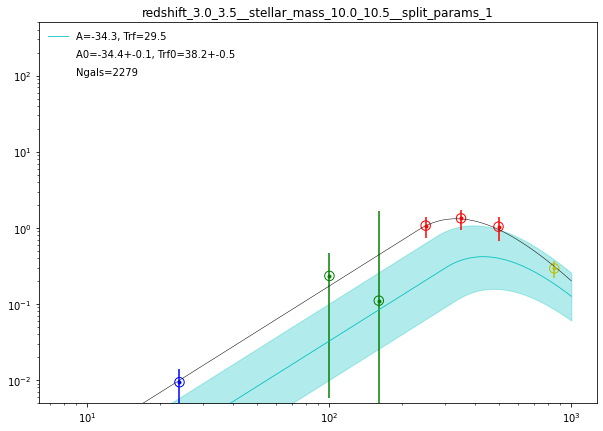

In [50]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)